# **Seam Carving Algorithm**

**Libraries**

In [ ]:
from google.colab import drive
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive/')

import sys; sys.path.append("/content/drive/My Drive/SeamCarving/")
from SeamCarving import SeamCarving 
from removePixels import removePixels
from reduceSC import reduceSC
from enlargeSC import enlargeSC
from ImageEnlargeH import ImageEnlargeH, getMmatrixH, getPixelListH
from ImageEnlargeV import ImageEnlargeV
from ImageEnlargeV import getMmatrixV, getPixelListV
from draw_roi import draw_roi
from objectRemovalV import objectRemovalV

example_id = 'example_10'
PATH = '/content/drive/My Drive/SeamCarving/examples/'
PATH += example_id + '.png'

image = io.imread(PATH)/255.0

if len(image.shape)<3:
  image = np.stack((image,image,image),axis=2)

print(image.shape)
plt.imshow(image)
io.imsave("/tmp/original.png",image)

**Enlarge Image Vertical (For drawing seams)**

In [ ]:
ResizedImage, Seams = ImageEnlargeH(image, 50)

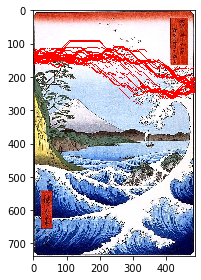

In [ ]:
seam_image = np.zeros_like(image)
np.copyto(seam_image, image, casting='same_kind', where=True)

for i in range(Seams.shape[0]):
  for j in range(Seams.shape[1]):
    seam_image[Seams[i,j], j, 0] = 1.0
    seam_image[Seams[i,j], j, 1] = 0.0
    seam_image[Seams[i,j], j, 2] = 0.0

io.imsave('/tmp/image.png', seam_image)
io.imshow(seam_image)

In [ ]:
plt.imshow(ResizedImage)
io.imsave('/tmp/image_resized.png', reamimage)

**Horizontal Enlarge  (For drawing seams)**

In [ ]:
ResizedImage, Seams = ImageEnlargeV(image, 50)

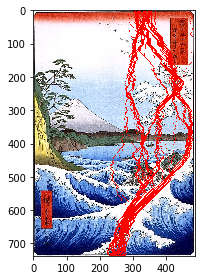

In [ ]:
seam_image = np.zeros_like(image)
np.copyto(seam_image, image, casting='same_kind', where=True)

for i in range(Seams.shape[0]):
  for j in range(Seams.shape[1]):
    seam_image[j, Seams[i,j], 0] = 1.0
    seam_image[j, Seams[i,j], 1] = 0.0
    seam_image[j, Seams[i,j], 2] = 0.0

io.imsave('/tmp/image.png', seam_image)
io.imshow(seam_image)

In [ ]:
plt.imshow(ResizedImage)
io.imsave('/tmp/image_resized.png', ResizedImage)

**Resizing (Reduce)**

In [ ]:
(738, 486, 3)

(375, 500, 3)

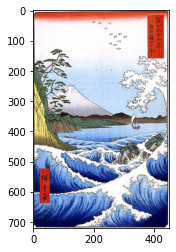

In [ ]:
final_size = (720, 450)
resized_image = reduceSC(image, final_size)
plt.imshow(resized_image)
io.imsave("/tmp/resultado.png",resized_image)

**Resizing (Enlarge)**

In [ ]:
image[:,:,0:3].shape

(607, 960, 3)

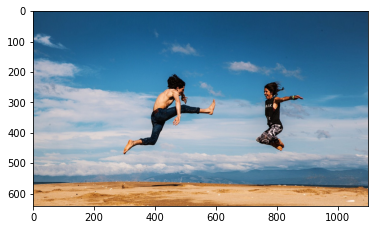

In [ ]:
final_size = (640, 1100)
resized_image = enlargeSC(image[:,:,0:3], final_size)
plt.imshow(resized_image)
io.imsave("/tmp/resultado.png",resized_image)

**Object Removal using vertical seams (In this case)**

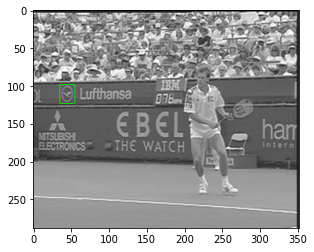

In [ ]:
ROI = [35, 98, 25, 20] #x, y, alto, ancho
image_roi = draw_roi(image, ROI)
plt.imshow(image_roi)

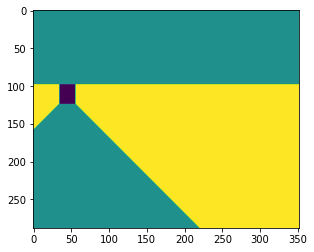

In [ ]:
rem_image = objectRemovalV(image, ROI)
#plt.imshow(rem_image)

In [ ]:
resized_image = enlargeSC(rem_image, (288, 352))

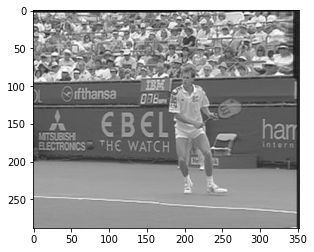

In [ ]:
plt.imshow(resized_image)
plt.imsave('remove_result.png', resized_image)

**SeamCarvingEnergy**

In [ ]:
from skimage import io
import numpy as np
import scipy.signal

#Función especifica que devuelve la energía del seam correspondiente, especificado mediante una lista de pixeles
def SeamCarvingEnergy(image, pixelListRemove): #If True Vertical, if False Horizontal

  #Sobel's filter
  Gx = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
  Gy = np.transpose(Gx)

  Ix = scipy.signal.convolve2d(image[:,:,0], Gx, mode='same')
  Iy = scipy.signal.convolve2d(image[:,:,0], Gy, mode='same')
  
  #Energy operator
  e = abs(Ix) + abs(Iy)

  EnergySeam = 0;
  for i in range(len(pixelListRemove)):
    EnergySeam = EnergySeam + e[pixelListRemove[i][0]][pixelListRemove[i][1]]

  return EnergySeam



**OptimalSeamCarving segun el coste mas pequeño**

In [ ]:
#Función especifica que aplica el metodo SeamCarving en varias iteraciones. En cada iteración se compara el coste entre un seams vertical 
#y un seams horizontal, eligiendo el coste mínimo, es decir el óptimo.
def OptimalSeamCarving(image, numIter):
  imageResultado = image

  for i in range(numIter):
    pixelRemovalVertical = SeamCarving(imageResultado, True)
    pixelRemovalHorizontal = SeamCarving(imageResultado, False)
    EnergyVertical = SeamCarvingEnergy(imageResultado, pixelRemovalVertical)
    EnergyHorizontal = SeamCarvingEnergy(imageResultado, pixelRemovalHorizontal)

    if(EnergyVertical <= EnergyHorizontal):
      imageResultado = removePixels(imageResultado, pixelRemovalVertical, True)
    else:
      imageResultado = removePixels(imageResultado, pixelRemovalHorizontal, False)

  return imageResultado

**Content Amplification**


In [ ]:
from skimage.transform import resize

#Función especifica que aplica una amplificación del contenido a un imagen especifica. Según una cantidad determinada, se aumenta 
#la resolución tanto en columnas como en filas, y luego posteriomente se aplica el metodo Seam Carving hasta alcanzar la misma resolución
#de la imagen inicial
def contentAmplification(image, dimResolution):

  img_ampl = resize(image,(image.shape[0]+dimResolution,image.shape[1]+dimResolution), anti_aliasing = True)
  image_resultado = reduceSC(img_ampl,(image.shape[0], image.shape[1]))

  return image_resultado

**Pruebas**

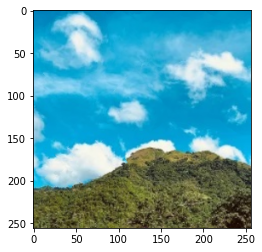

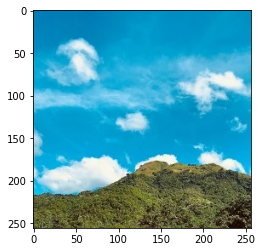

In [ ]:

image_resultado = contentAmplification(image,50)

plt.figure(1)
plt.imshow(image_resultado)
plt.figure(2)
plt.imshow(image)




**Eliminación de pixeles**


In [ ]:
from scipy.ndimage import gaussian_filter
import cv2

#Función especifica que obtiene una imagen con los pixeles eliminados de una determinada una ROI definida, indicando la posición de la 
#esquina superior izquierda y las dimensiones de dicha región. También se introduce la imagen de donde queremos eliminar los pixeles, 
#obteniendo de este metodo la imagen resultado 
def eliminatePixelsSC(image, pos, dim):

  filas = image.shape[0]
  columnas = image.shape[1]

  if(pos[0]+dim[0] > filas or pos[1]+dim[1] > columnas):
    print('Incorrect target section')
    return image
  else:
    if(dim[0] < dim[1]):
      VoH = False
      NumIter = dim[0]
      M = getMmatrixH(image[:,:,0]) 
    else:
      VoH = True
      NumIter = dim[1]
      M = getMmatrixV(image[:,:,0]) 

    image_resultado = image 

    #Fuerza el borrado de la sección, obligando a ciertos rango de seams a ser borrado
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        
        #Partiendo desde seams verticales
        if(VoH):
          if( (i >= pos[0] and i <= pos[0]+dim[0]) and (j >= pos[1] and j <= pos[1]+dim[1])):
            M[i,j] = -1e20
          elif( (i >= pos[0] and i <= pos[0]+dim[0]) and (j < pos[1] or j >= pos[1]+dim[1]) ):
            M[i,j] = M[i,j] + 1e20
          elif( (i > pos[0] + dim[0]) and (j < pos[1] - (i - (pos[0] + dim[0])))):
            M[i,j] = M[i,j] + 1e20
          elif( (i > pos[0] + dim[0]) and (j > (pos[1] + dim[1]) + (i - (pos[0] + dim[0])))):
            M[i,j] = M[i,j] + 1e20
          else:
            M[i,j] = M[i,j] - 100

        #Partiendo desde seams horizontales
        else:
          if( (i >= pos[0] and i <= pos[0]+dim[0]) and (j >= pos[1] and j <= pos[1]+dim[1]) ):
            M[i,j] = -1e20
          elif((i < pos[0] or i > pos[0]+dim[0] ) and ( j >= pos[1] and j <= pos[1]+dim[1])):
            M[i,j] = M[i,j] + 1e20
          elif( ( j > pos[1] + dim[1]) and ( i <  pos[0] - (j - (pos[1] + dim[1]))) ):
            M[i,j] = M[i,j] + 1e20
          elif( ( j > pos[1] + dim[1]) and ( i >  pos[0] + dim[0] + (j - (pos[1] + dim[1]))) ):
            M[i,j] = M[i,j] + 1e20
          else:
            M[i,j] = M[i,j] - 100
   
    #Representación de la matriz M
    #plt.figure(1)
    #plt.imshow(M)

    for k in range(NumIter):   

      if(VoH == False):
        pixelList = getPixelListH(M)
        #print(str(M.shape[0])+" "+str(M.shape[1]))
        image_resultado = removePixels(image_resultado,pixelList,VoH)
        M = removePixelsM(M, pixelList, VoH)
        #print(str(M.shape[0])+" "+str(M.shape[1]))
      else:
        pixelList =getPixelListV(M)
        #print(str(M.shape[0])+" "+str(M.shape[1]))
        image_resultado = removePixels(image_resultado,pixelList,VoH)
        M = removePixelsM(M, pixelList, VoH)
        #print(str(M.shape[0])+" "+str(M.shape[1]))

    return image_resultado




**removePixelsM**

In [ ]:
import numpy as np

#Función especifica que elimina los pixeles de una matriz de coste denominada M. A partir de una lista de pixeles y una variable boleana
#que indica si se trata de un seams vertical o horizontal elimina dicho seams en relación con la matriz M introducida
def removePixelsM(M, pixelList, VoH): # VoH: 1 if Vertical, 0 if Horizontal
  pixelList.reverse()

  if(VoH == 1):
    M_result = np.zeros([M.shape[0], M.shape[1]-1])
    for ind_fila in range(M.shape[0]):
      for ind_Colum in range(M.shape[1]-1):
        if(pixelList[ind_fila][1] > ind_Colum):                             
          M_result[ind_fila, ind_Colum] = M[ind_fila, ind_Colum]
        else:                                                                   
          M_result[ind_fila, ind_Colum] = M[ind_fila, ind_Colum+1]

  else:
    M_result = np.zeros([M.shape[0]-1, M.shape[1]])
    for ind_Colum in range(M.shape[1]):
      for ind_fila in range(M.shape[0]-1):         
        if(pixelList[ind_Colum][0] > ind_fila):
          M_result[ind_fila, ind_Colum] = M[ind_fila, ind_Colum]
        else:          
          M_result[ind_fila, ind_Colum] = M[ind_fila+1, ind_Colum]

  return M_result


Seleccion de eliminación


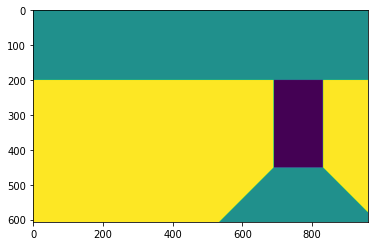

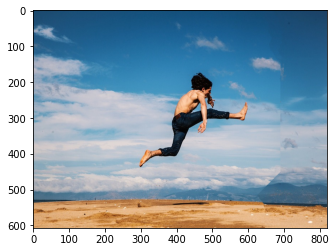

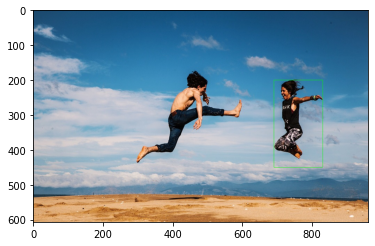

In [ ]:
#image_resultado = eliminatePixelsSC(image, [100,60], [100,90]) #Ejemplo6
#image_resultado = eliminatePixelsSC(image, [125,225], [25,27]) #Ejemplo8
#image_resultado = eliminatePixelsSC(image, [140,0], [100,140]) #Ejemplo9
#image_resultado = eliminatePixelsSC(image, [350,325], [70,50]) #Ejemplo10
#image_resultado = eliminatePixelsSC(image, [200,600], [150,110]) #Ejemplo11
image_resultado = eliminatePixelsSC(image, [200,690], [250,140]) #Ejemplo11

ROI = [690, 200, 250, 140] #x, y, alto, ancho
image_roi = draw_roi(image, ROI)

plt.figure(2)
plt.imshow(image_resultado)
plt.figure(3)
plt.imshow(image_roi)




